In [ ]:
# ML_in_Finance-GIRL-wealth-management
# Author: Igor Halperin and Matthew Dixon
# Version: 1.0 (12.8.2019)
# License: MIT
# Email: ighalp@gmail.com
# Notes: tested on Mac OS X with Python 3.6 and PyTorch 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Dixon M.F., I. Halperin and P. Bilokon, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 
# 
# Update: 2025-ß7-08 by Moccazio

## Overview 

This notebook demonstrates the application of G-learning and GIRL for optimization of a defined contribution retirement plan. The notebook extends the G-learning notebook in Chapter 10 with an example of applying GIRL to infer the parameters of the G-learner used to generate the trajectories.

In [2]:
import time
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt 
%matplotlib inline
import torch
import torch.optim as optim
import pandas as pd
import scipy 
from scipy.optimize import minimize
from scipy.stats import linregress
from pandas_datareader import data
from G_learning_portfolio_opt import G_learning_portfolio_opt
from get_loss_function import *
import gc
%load_ext autoreload

%autoreload 2

In [3]:
torch.__version__

'2.7.0'

In [4]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [5]:
# set the device
device = 'mps' if torch.cuda.is_available() else 'cpu'

## Simulate portfolio data

### Extract market and stock data

In [6]:
start_year= 2011 # For CAPM regression
end_year=2020
R = 0.01/4  # quarterly risk free rate
N=252
dt = 1
num_risky_assets = 99 
quarters=['01-01', '03-31', '06-30', '09-30','12-31']
start_date=quarters[0] +'-'+str(start_year)
end_date=quarters[4] +'-'+str(end_year)
periods=[]
for year in range(start_year, end_year):
    for j in range(0,4):
        periods.append(str(year)+'Q'+str(j+1))
        
bAcquire = False # toggle to True to acquire data        

In [7]:
tickers=['AAPL', 'ACLS', 'ADBE', 'ALLT', 'ALOT', 'AMAT', 'AMKR', 'ANSS', 'ASML',
       'AVGO', 'AVID', 'AWRE', 'AXTI', 'AZPN', 'BBSI', 'BIDU', 'BLKB', 'BRKS',
       'CAMP', 'CCMP', 'CCRN', 'CERN', 'CHKP', 'CPSI', 'CREE', 'CRUS', 'CSCO',
       'CSGS', 'CSIQ', 'CSPI', 'CTSH', 'CTXS', 'CVLT', 'DGII', 'DSPG', 'EGAN',
       'ELTK', 'EMKR', 'EPAY', 'ERII', 'EVOL', 'EXTR', 'FFIV', 'FISV', 'FLEX',
       'FORM', 'FSLR', 'FTNT', 'GLUU', 'GOOG', 'GSIT', 'HIMX', 'HLIT', 'HSII',
       'HSTM', 'IDN', 'IMMR', 'INOD', 'INTU', 'IPGP', 'ISSC', 'ITRN', 'IVAC',
       'JCOM', 'JKHY', 'JOBS', 'KFRC', 'KOPN', 'KTCC', 'KVHI', 'LOGI', 'LPSN',
       'LPTH', 'LRCX', 'LTRX', 'MANH', 'MCHP', 'MGIC', 'MGRC', 'MOSY', 'MPWR',
       'MRVL', 'MSFT', 'MSTR', 'MXIM', 'NATI', 'NTAP', 'NTCT', 'NVDA', 'OMCL',
       'OSIS', 'OTEX', 'PCTI', 'PDFS', 'PEGA', 'PLAB', 'PLUS', 'PRFT', 'PXLW'] ## 99 symbols

In [8]:
if bAcquire:
    stock_data = data.DataReader(tickers, 'yahoo', start_date, end_date)['Adj Close']
    stock_data.to_csv('stockdata2011-2021.csv', header=tickers)
else:
    stock_data=pd.read_csv('stockdata2011-2021.csv')
    stock_data= stock_data.set_index('Date')
    stock_data.index=pd.to_datetime(stock_data.index) 

In [9]:
if bAcquire:
    market_data= data.DataReader('^GSPC', 'yahoo', start_date, end_date)['Adj Close']
    market_data.to_csv('marketdata2011-2021.csv', header=['^GSPC'])
else:    
    market_data=pd.read_csv('marketdata2011-2021.csv')
    market_data=market_data.set_index('Date')
    market_data.index=pd.to_datetime(market_data.index) 

In [10]:
risky_asset_returns=stock_data[tickers].pct_change(periods=1)
market_returns=market_data.pct_change(periods=1)

risky_asset_returns=risky_asset_returns.dropna()
market_returns=market_returns.dropna()
risky_asset_returns.index=pd.to_datetime(risky_asset_returns.index)  
market_returns.index=pd.to_datetime(market_returns.index)  

risky_asset_vol = risky_asset_returns.std()
market_vol = market_returns.std()

In [11]:
# Use CAPM to estimate the expected risky asset returns
def get_expected_R_CAPM():
    expected_R = pd.DataFrame(index = tickers,columns = periods)
    
    print("Period, R^2, slope, intercept")
    for year in range(start_year+1,end_year):
      for j in range(0,4): 
       
        if (j==0): #always fit CAPM from the previous period
            mask = (risky_asset_returns.index > str(year-1)+'-'+quarters[2]) & (risky_asset_returns.index < str(year-1)+'-'+quarters[3])
        else:    
            mask = (risky_asset_returns.index > str(year)+'-'+quarters[j-1]) & (risky_asset_returns.index < str(year)+'-'+quarters[j])
        
        x = market_returns.loc[mask].values 
        xs_rets=[]
        xs_rets_M=[]
        xs_ret_M = (1+np.mean(x))**252/4 -1-R # quarterly excess expected market returns
          
        for ticker in tickers:
           #print(str(year)+'-'+quarters[j])
           
           if (j==0): #always fit CAPM from the previous period
                mask = (stock_data[ticker].index > str(year-1)+'-'+quarters[2]) & (stock_data[ticker].index < str(year-1)+'-'+quarters[3])
           else:    
                mask = (stock_data[ticker].index > str(year)+'-'+quarters[j-1]) & (stock_data[ticker].index < str(year)+'-'+quarters[j])
       
           prices = stock_data.loc[mask][ticker].values 
          
           xs_ret= (prices[-1] - prices[0])/prices[0] -R # quarterly excess risky asset returns
           
           xs_rets.append(xs_ret)
            
           if (j==0): #always fit CAPM from the previous period
             mask = (risky_asset_returns.index > str(year-1)+'-'+quarters[2]) & (risky_asset_returns.index < str(year-1)+'-'+quarters[3])
           else:    
             mask = (risky_asset_returns.index > str(year)+'-'+quarters[j-1]) & (risky_asset_returns.index < str(year)+'-'+quarters[j])
        
           y = risky_asset_returns.loc[mask][ticker].values.flatten() # extract all dates in each year      
           x = market_returns.loc[mask].values.flatten() 
           
           beta = np.cov(x,y)[0,1]/np.var(x)
           xs_rets_M.append(beta*xs_ret_M)
            
        model=linregress(xs_rets_M,xs_rets) # fit CAPM model
        print(str(year)+'-'+str(quarters[j]), model.rvalue, model.intercept, model.slope)
        
        mask = (risky_asset_returns.index > str(year)+'-'+quarters[j]) & (risky_asset_returns.index < str(year)+'-'+quarters[j+1])
        x = market_returns.loc[mask].values.flatten()    
        for ticker in tickers:
            y = risky_asset_returns.loc[mask][ticker].values.flatten() # extract all dates in each year      
            if len(x)==len(y):
                beta = np.cov(x,y)[0,1]/np.var(x)
                expected_R.loc[ticker,str(year)+'Q'+str(j+1)] = R+ model.intercept + model.slope*beta*((1+np.mean(x))**252/4 -1-R)    
            else:
                print('Error in ' + ticker + "," + str(len(x)) + "," + str(len(y)))
     
    return expected_R

In [12]:
# Use OLS on historical training data for each each ticker 
def get_expected_R_OLS():
    expected_R = pd.DataFrame(index = tickers,columns = periods)
    
    
    for ticker in tickers:
        print("Period, R^2, slope, intercept")
        ys_rets=[]
        xs_rets_M=[]
        for year in range(start_year+1,end_year-2):
              for j in range(0,4): 
                 if (j==0): #always fit CAPM from the previous period
                    mask = (stock_data[ticker].index > str(year-1)+'-'+quarters[2]) & (stock_data[ticker].index < str(year-1)+'-'+quarters[3])
                 else:    
                    mask = (stock_data[ticker].index > str(year)+'-'+quarters[j-1]) & (stock_data[ticker].index < str(year)+'-'+quarters[j])
          
                      
                 prices = stock_data.loc[mask][ticker].values 
          
                 ys_ret= (prices[-1] - prices[0])/prices[0] -R # quarterly excess risky asset returns
           
                 ys_rets.append(ys_ret)
                  
                 if (j==0): #always fit CAPM from the previous period
                    mask = (risky_asset_returns.index > str(year-1)+'-'+quarters[2]) & (risky_asset_returns.index < str(year-1)+'-'+quarters[3])
                 else:    
                    mask = (risky_asset_returns.index > str(year)+'-'+quarters[j-1]) & (risky_asset_returns.index < str(year)+'-'+quarters[j])
          
                
                 x = market_returns.loc[mask].values.flatten() 
                 xs_ret_M = (1+np.mean(x))**252/4 -1-R # quarterly excess expected market returns
                 y = risky_asset_returns.loc[mask][ticker].values.flatten() # extract all dates in each year
                
                 if len(x)==len(y):
                     beta = np.cov(x,y)[0,1]/np.var(x)
                     xs_rets_M.append(beta*xs_ret_M)
                 else:
                     print('Error in ' + ticker + "," + str(len(x)) + "," + str(len(y)))
        model=linregress(xs_rets_M,ys_rets) 
        
        print(ticker, model.rvalue, model.intercept, model.slope)
        for year in range(end_year-2,end_year):
              for j in range(0,4): 
                 if (j==0): #always fit CAPM from the previous period
                    mask = (risky_asset_returns.index > str(year-1)+'-'+quarters[2]) & (risky_asset_returns.index < str(year-1)+'-'+quarters[3])
                 else:    
                    mask = (risky_asset_returns.index > str(year)+'-'+quarters[j-1]) & (risky_asset_returns.index < str(year)+'-'+quarters[j])
          
                 x = market_returns.loc[mask].values.flatten()    
                 y = risky_asset_returns.loc[mask][ticker].values.flatten() # extract all dates in each year
                 
                 if len(x)==len(y):
                    beta = np.cov(x,y)[0,1]/np.var(x)
                    expected_R.loc[ticker,str(year)+'Q'+str(j+1)] = R+ model.intercept + model.slope*beta*((1+np.mean(x))**252/4 -1-R)    
                 else:
                    print('Error in ' + ticker + "," + str(len(x)) + "," + str(len(y)))

    return expected_R

In [13]:
# Use OLS on historical training data for each each ticker 
def get_expected_R_Oracle(c):
    expected_R = pd.DataFrame(index = tickers,columns = periods)
    
    
    for ticker in tickers:
        print("Period, R^2, slope, intercept")
        ys_rets=[]
        xs_rets_M=[]
        
        
        xs_rets = []
        ys_rets = []
        for year in range(start_year+1,end_year):
              for j in range(0,4): 
                 if (j==0): #always fit CAPM from the previous period
                    mask = (stock_data[ticker].index > str(year-1)+'-'+quarters[2]) & (stock_data[ticker].index < str(year-1)+'-'+quarters[3])
                 else:    
                    mask = (stock_data[ticker].index > str(year)+'-'+quarters[j-1]) & (stock_data[ticker].index < str(year)+'-'+quarters[j])
          
                      
                 prices = stock_data.loc[mask][ticker].values 
          
                 if (j==0): #always fit CAPM from the previous period
                    mask = (risky_asset_returns.index > str(year-1)+'-'+quarters[2]) & (risky_asset_returns.index < str(year-1)+'-'+quarters[3])
                 else:    
                    mask = (risky_asset_returns.index > str(year)+'-'+quarters[j-1]) & (risky_asset_returns.index < str(year)+'-'+quarters[j])
          
                    
                 y = risky_asset_returns.loc[mask][ticker].values # extract all dates in each year  
                 x = market_returns.loc[mask].values 
                   
                 mu = (1+np.mean(x))**252/4 -1-R # quarterly excess expected market returns
                 sigma= np.std(x)*2 # scale by sqrt(4)
                 if len(x)==len(y):
                     
                     beta = np.cov(x.flatten(),y.flatten())[0,1]/np.var(x.flatten())
                     ret= (prices[-1] - prices[0])/prices[0]# quarterly excess risky asset returns
                     xs_rets.append(c*ret + (1-c)*beta*(sigma*np.random.randn() +mu) -R)
                     expected_R.loc[ticker,str(year)+'Q'+str(j+1)] = R+xs_rets[-1]    
                     ys_rets.append(ret)
                 else:
                     print('Error in ' + ticker + "," + str(len(x)) + "," + str(len(y)))
        model=linregress(xs_rets,ys_rets) 
        
        print(ticker, model.rvalue, model.intercept, model.slope)
                
    return expected_R

In [14]:
write_data_to_csv = True
if write_data_to_csv == True: 
    #expected_risky_returns=get_expected_R_CAPM()
    #expected_risky_returns=get_expected_R_Oracle(0.2)
    expected_risky_returns=get_expected_R_OLS()
    expected_risky_returns.to_csv('expected_R.csv', sep=',', header=True, index=True)
else:
    expected_risky_returns= pd.read_csv('expected_R.csv', index_col = 0).dropna()

Period, R^2, slope, intercept
AAPL 0.4128576709992116 0.22975471054968838 0.229217903054285
Period, R^2, slope, intercept
ACLS -0.2033099271253836 -0.09583206645220543 -0.10233918598992814
Period, R^2, slope, intercept
ADBE 0.08655997087654393 0.0968686577498772 0.051000171275371625
Period, R^2, slope, intercept
ALLT -0.2374596996353927 -0.14784605326943645 -0.07812773283811171
Period, R^2, slope, intercept
ALOT 0.44902253210222953 0.04176381981802089 0.15449920547518134
Period, R^2, slope, intercept
AMAT -0.17389830024349986 -0.04639333044121124 -0.10119068987517803
Period, R^2, slope, intercept
AMKR -0.07180193240015613 -0.02952414948030029 -0.043227417686834746
Period, R^2, slope, intercept
ANSS 0.10161491936575615 0.07072314149968154 0.04651677431576067
Period, R^2, slope, intercept
ASML 0.07654213625457028 0.0976891448963402 0.04142961717653306
Period, R^2, slope, intercept
AVGO 0.45062840684470484 0.3413616188123628 0.230534714829632
Period, R^2, slope, intercept
AVID -0.06774607

In [15]:
investment_periods=[]
for year in range(end_year-2, end_year):
    for j in range(0,4):
        investment_periods.append(str(year)+'Q'+str(j+1))

In [16]:
# Extract the risky quarterly returns
risky_asset_R = pd.DataFrame(index = tickers,columns = investment_periods)
expected_asset_R = pd.DataFrame(index = tickers,columns = investment_periods) 
for year in range(end_year-2,end_year):
      for j in range(0,4): 
            #stock_data['AAPL'].groupby(pd.Grouper(freq='Q'))
            mask = (stock_data.index > str(year)+'-'+quarters[j]) & (stock_data.index < str(year)+'-'+quarters[j+1])
            quarterly_returns=((stock_data[mask].iloc[-1]- stock_data[mask].iloc[0])/stock_data[mask].iloc[0]).values
            #annualized_quarterly_returns=(1+quarterly_returns)**4-1
            risky_asset_R.loc[:,str(year)+'Q'+str(j+1)] =quarterly_returns
            expected_asset_R.loc[:,str(year)+'Q'+str(j+1)]= expected_risky_returns.loc[:,str(year)+'Q'+str(j+1)]

In [17]:
risky_asset_returns=risky_asset_R
expected_risky_returns=expected_asset_R

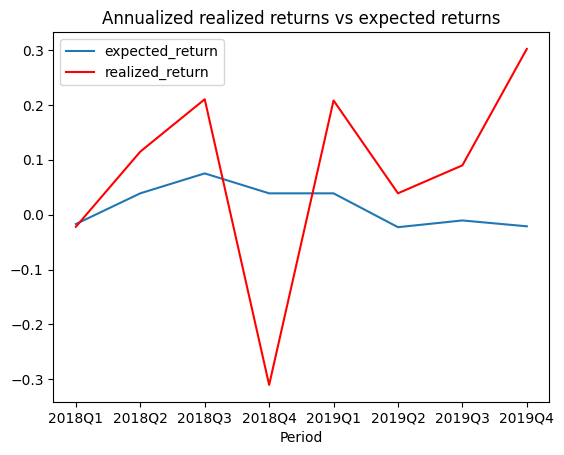

In [18]:
# Compare the realized and expected returns
# Note that they should appear correlated.

# pick a random asset ID to show
asset_idx =  tickers[0]

plt.plot(investment_periods, expected_risky_returns.loc[asset_idx,:].values,label='expected_return')
plt.plot(investment_periods,risky_asset_returns.loc[asset_idx,:].values,label='realized_return',color='r')
plt.legend()
plt.xlabel('Period')
plt.title('Annualized realized returns vs expected returns')
plt.show()

In [19]:
risky_asset_returns=risky_asset_returns.T
expected_risky_returns=expected_risky_returns.T

In [20]:
num_steps=np.shape(expected_risky_returns)[0]

In [21]:
num_steps

8

### Compute the empirical correlation matrix using realized returns

In [22]:
# Ensure the data is float before computing covariance
cov_mat_r = np.cov(risky_asset_returns.astype(float).T)  # correlation matrix
print(cov_mat_r.shape)
D, v = np.linalg.eigh(cov_mat_r)
eigenvals = D[::-1]  # put them in a descended order

(99, 99)


In [23]:
# eigenvalues: the largest eigenvalue is the market factor 
eigenvals[0:10]

array([1.44142932e+00, 9.32583487e-01, 6.05832266e-01, 4.48157769e-01,
       3.15410819e-01, 2.61472712e-01, 2.14440432e-01, 3.58699062e-16,
       3.26161453e-16, 2.92750154e-16])

In [24]:
cov_mat_torch = torch.tensor(cov_mat_r)
torch.pinverse(cov_mat_torch)

tensor([[ 0.0828,  0.0510,  0.0315,  ...,  0.0124,  0.0335,  0.0513],
        [ 0.0510,  0.1789,  0.0310,  ...,  0.0070,  0.0272, -0.0620],
        [ 0.0315,  0.0310,  0.1144,  ..., -0.0406,  0.0398, -0.1759],
        ...,
        [ 0.0124,  0.0070, -0.0406,  ...,  0.0528, -0.0039,  0.1020],
        [ 0.0335,  0.0272,  0.0398,  ..., -0.0039,  0.0476, -0.0602],
        [ 0.0513, -0.0620, -0.1759,  ...,  0.1020, -0.0602,  0.5031]],
       dtype=torch.float64)

### Add a riskless bond as one more asset

In [25]:
num_assets = num_risky_assets + 1
bond_val = 100.0
init_asset_vals = np.hstack((np.array([bond_val]), stock_data.iloc[0,:].values)) # add the bond to initial assets

### Make the initial portfolio 

In [26]:
# consider here two choices: equal or equally-weighted 
init_port_choice =  'equal' 
init_cash = 1000.0
init_total_asset = np.sum(init_asset_vals)
x_vals_init = np.zeros(num_assets)

if init_port_choice == 'equal': 
    # hold equal amounts of cash in each asset
    amount_per_asset = init_cash/num_assets
    x_vals_init = amount_per_asset * np.ones(num_assets)
elif init_port_choice == 'equally_weighted':
    amount_per_asset = init_cash/init_total_asset
    x_vals_init = amount_per_asset * init_asset_vals 

### Make the target portfolio

In [27]:
# make a target portfolio term structure by defining it as the initial portfolio growing at some fixed and high rate
target_portfolio = [init_cash]
target_return = 0.15 
coeff_target = 1.1 

for i in range(1, num_steps):
    target_portfolio.append(target_portfolio[i-1]*np.exp(dt * target_return) )
    
target_portfolio = coeff_target*np.array(target_portfolio)    
print(target_portfolio[0], target_portfolio[-1])

1100.0 3143.416229869479


### Define model parameters

In [28]:
fee_bond = 0.05 
fee_stock = 0.015 
gamma = 0.95 
all_fees = np.zeros(num_risky_assets + 1)
all_fees[0] = fee_bond
all_fees[1:] = fee_stock
Omega_mat = np.diag(all_fees)
exp_returns = expected_risky_returns
Sigma_r = cov_mat_r

# Generate the benchmark target portfolio by growing the initial portfolio value at rate eta
target_return =  0.5 
benchmark_portf = [init_cash * np.exp(dt * target_return)]

for i in range(1,num_steps):
    benchmark_portf.append(benchmark_portf[i-1]*np.exp(dt * target_return))   
print(benchmark_portf[0], benchmark_portf[-1])

1648.7212707001281 54598.15003314424


## G-learning

Produce a list of trajectories, where each trajectory is a list made of state-action pairs

In [29]:
lambd = 0.001 # keep fixed
#omega = 1.81
beta = 1000.0 # fixed fixed
#eta = 1.82
#rho = 0.9

#### Parameter search for highest sharpe

In [30]:
SR_G_max=-10
bTune = False

In [31]:
if bTune:
 # There is a memory leak in the G_learning_portfolio_opt due to copy() and this may crash
 for omega in np.arange(1.6,2.5,0.2):
  for eta in np.arange(1.6,2.5,0.2):
   for rho in np.arange(0.0,1.0,0.2):      

    reward_params=[lambd, omega, eta, rho]
    print(reward_params)
    # Create a G-learner
    G_learner = G_learning_portfolio_opt(num_steps,
                     reward_params,  
                     beta,                
                     benchmark_portf,
                     gamma, 
                     num_risky_assets,
                     R,
                     np.array(expected_risky_returns, dtype='float64'), # array of shape num_steps x num_stocks
                     Sigma_r,     # covariance matrix of returns of risky matrix                    
                     x_vals_init, # array of initial values of len (num_stocks+1)
                     use_for_WM = True) # use for wealth management tasks

    G_learner.reset_prior_policy()
    error_tol=1.e-8
    max_iter_RL = 200
    G_learner.G_learning(error_tol, max_iter_RL)

    num_sim = 100
    #trajs = []
    np.random.seed(0)
    torch.manual_seed(0)
    t_0 = time.time()
    x_vals = [x_vals_init]
    returns_all = []
    consumption=np.array([0]*num_steps, dtype='float64')

    for n in range(num_sim):
        #this_traj = []
        x_t = x_vals_init[:]
        returns_array = []
        for t in range(0,num_steps):       
            mu_t = G_learner.u_bar_prior[t,:] + G_learner.v_bar_prior[t,:].mv(torch.tensor(x_t))
            u_t = np.random.multivariate_normal(mu_t.detach().numpy(), G_learner.Sigma_prior[t,:].detach().numpy())
            # compute new values of x_t
            x_next = x_t + u_t
            risky_asset_return = risky_asset_returns.iloc[t,:]
            returns = np.hstack((R*dt, risky_asset_return))
            x_next = (1+returns)*x_next
            port_returns=(x_next.sum() - x_t.sum() - np.sum(u_t) -fee_stock*np.abs(u_t).sum())/x_t.sum()
            consumption[t] += np.sum(u_t)
            #this_traj.append((x_t, u_t))
            x_t = x_next  # rename
            returns_array.append(port_returns) 
        # end the loop over time steps
        #trajs.append(this_traj)
        returns_all.append(returns_array)

    print('Done simulating trajectories in %f sec'% (time.time() - t_0))        
   
    returns_all_G = returns_all
    
    SR_G = 0
    for i in range(num_sim):
      SR_G += (np.mean(returns_all_G[i])-R*dt)/np.std(returns_all_G[i])
    
    del G_learner, returns_all,port_returns, returns, returns_array
    gc.collect()
    SR_G/=num_sim
    print(SR_G)
    if (SR_G> SR_G_max):
        SR_G_max=SR_G
        best_params=reward_params
        

In [32]:
lambd = 0.001 # keep fixed
omega = 1.8
beta = 1000.0 # fixed fixed
eta = 2.0
rho = 0.8

In [33]:
reward_params = [lambd, omega, eta, rho]
print(reward_params)

# Create a G-learner
G_learner = G_learning_portfolio_opt(
    num_steps,
    reward_params,
    beta,
    benchmark_portf,
    gamma,
    num_risky_assets,
    R,
    np.array(expected_risky_returns, dtype='float64'),
    Sigma_r,
    x_vals_init,
    use_for_WM=True
)

G_learner.reset_prior_policy()
error_tol = 1.e-8
max_iter_RL = 200
G_learner.G_learning(error_tol, max_iter_RL)

num_sim = 500
trajs = []
np.random.seed(0)
torch.manual_seed(0)
t_0 = time.time()
x_vals = [x_vals_init]
returns_all = []
consumption = np.zeros(num_steps, dtype='float64')

for n in range(num_sim):
    this_traj = []
    x_t = x_vals_init.copy()
    returns_array = []
    for t in range(num_steps):
        # Ensure all tensors are detached and converted to numpy before use
        mu_t = (
            G_learner.u_bar_prior[t, :].detach().cpu().numpy()
            + G_learner.v_bar_prior[t, :, :].detach().cpu().numpy().dot(x_t)
        )
        cov_t = G_learner.Sigma_prior[t, :, :].detach().cpu().numpy()
        u_t = np.random.multivariate_normal(mu_t, cov_t)
        # compute new values of x_t
        x_next = x_t + u_t
        risky_asset_return = risky_asset_returns.iloc[t, :].astype(float)
        returns = np.hstack((R * dt, risky_asset_return))
        x_next = (1 + returns) * x_next
        port_returns = (
            (x_next.sum() - x_t.sum() - np.sum(u_t) - fee_stock * np.abs(u_t).sum()) / x_t.sum()
        )
        # Avoid in-place operation (use out-of-place addition)
        consumption[t] = consumption[t] + float(np.sum(u_t))
        this_traj.append((x_t.copy(), u_t.copy()))
        x_t = x_next.copy()
        returns_array.append(port_returns)
    trajs.append(this_traj)
    returns_all.append(returns_array)

print('Done simulating trajectories in %f sec' % (time.time() - t_0))

returns_all_G = returns_all

[0.001, 1.8, 2.0, 0.8]
Doing G-learning, it may take a few seconds...
Done simulating trajectories in 26.864642 sec


In [34]:
#from __future__ import print_function  # for Python2
#import sys
#max_mem=0
#local_vars = list(locals().items())
#for var, obj in local_vars:
#    mem= sys.getsizeof(obj)
#    if mem>max_mem:
#        max_mem=mem
#        max_var=var
#    print(var, mem)   
#print("---------")    
#print (max_var, max_mem)    

In [35]:
np.save('State_act_trajs.npy', trajs)  # save trajectories 

In [36]:
trajs = np.load('State_act_trajs.npy')

### Calculate performance of G-learner (Diagnostics only)

In [37]:
SR_G = 0
for i in range(num_sim):
  SR_G += (np.mean(returns_all_G[i])-R*dt)/np.std(returns_all_G[i])
SR_G/=num_sim    

In [38]:
r_G=np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
  for i in range(num_sim):
    r_G[n]+=returns_all_G[i][n]
  r_G[n]/=num_sim

Text(0, 0.5, 'Sample Mean Returns')

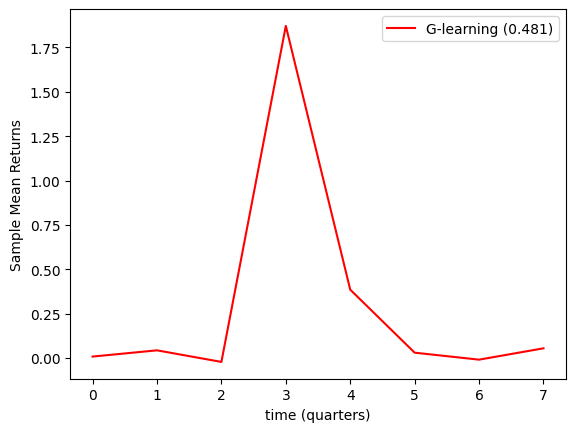

In [39]:
plt.plot(r_G, label='G-learning (' + str(np.round(SR_G, 3)) + ')', color='red')
#plt.plot(r_fixed, label='Equi-weighted (' + str(np.round(SR_fixed,3)) + ')', color='black')
#plt.plot(r_GIRL, label='GIRL (' + str(np.round(SR_GIRL,3)) + ')', color='blue')

plt.legend()
plt.xlabel('time (quarters)')
plt.ylabel('Sample Mean Returns')

## Benchmark against the equal weighted portfolio

In [40]:
num_sim = 500
t_0 = time.time()
x_vals = [x_vals_init]
returns_all = []

for n in range(num_sim):
    
    x_t = x_vals_init[:]
    returns_array = []
    for t in range(0,num_steps): 
        u_t=0  # don't rebalance
        # compute new values of x_t
        x_next = x_t + u_t
        risky_asset_return = risky_asset_returns.iloc[t,:]
        returns = np.hstack((R*dt, risky_asset_return))
        #print(returns)
        x_next = (1+returns)*x_next
        port_returns=(x_next.sum() - x_t.sum() - np.sum(u_t) - fee_stock*np.abs(u_t).sum())/x_t.sum()
        
        x_t = x_next # rename
        returns_array.append(port_returns) 
    # end the loop over time steps
   
    returns_all.append(returns_array)

print('Done simulating trajectories in %f sec'% (time.time() - t_0))   

Done simulating trajectories in 0.135298 sec


In [41]:
returns_all_fixed = returns_all

In [42]:
SR_fixed=0
for i in range(num_sim):
  SR_fixed+=(np.mean(returns_all_fixed[i])-R*dt)/np.std(returns_all_fixed[i])

SR_fixed/=num_sim
print(SR_fixed)

0.292899296347987


In [43]:
r_fixed=np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
  for i in range(num_sim):
    r_fixed[n]+=returns_all_fixed[i][n]
  r_fixed[n]/=num_sim

Text(0, 0.5, 'Sample Mean Returns')

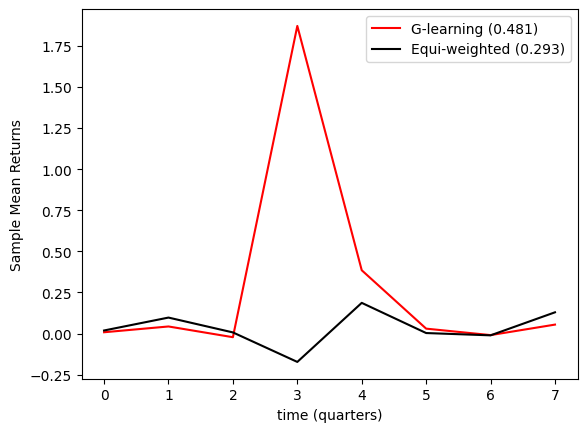

In [44]:
plt.plot(r_G, label='G-learning (' + str(np.round(SR_G,3)) + ')', color='red')
plt.plot(r_fixed, label='Equi-weighted (' + str(np.round(SR_fixed,3)) + ')', color='black')
#plt.plot(r_GIRL, label='GIRL (' + str(np.round(SR_GIRL,3)) + ')', color='blue')

plt.legend()
plt.xlabel('time (quarters)')
plt.ylabel('Sample Mean Returns')

## GIRL
Implement the optimizer for finding the optimal G-learning parameters by MLE.

In [45]:
def fun(x, grad_=False, rescale=1.0, constraint=False):
    y=np.array([0]*4, dtype='float32')
    z=x.copy()
    y[0] =lambd
    #y[0]/=sc[0]
    y[1]=z[0]/sc[0]
    y[2]=z[1]/sc[1]
    y[3]=z[2]/sc[2]
    
    with torch.no_grad():
       if grad_==False:
           if constraint:
            #y[0] = y[0]**2
            #y[0] = lambd
            y[1] = 1+y[1]**2
            y[2] = 1+y[2]**2
            y[3] = 1.0/(1.0+np.exp(-y[3]))
           print(y) 
           ret = rescale*get_loss(trajs,
                                 num_steps, 
                                 benchmark_portf, 
                                 gamma, 
                                 num_risky_assets, 
                                 R, 
                                 np.array(expected_risky_returns, dtype='float32'),
                                 Sigma_r, 
                                 x_vals_init, 
                                 max_iter_RL, 
                                 y,
                                 beta,
                                 len(trajs), 
                                 grad=grad_, 
                                 eps=1e-7).detach().numpy()

           print(ret)
           return ret
       else:
            f, df = get_loss(trajs,
                                 num_steps, 
                                 benchmark_portf, 
                                 gamma, 
                                 num_risky_assets,
                                 R, 
                                 np.array(expected_risky_returns, dtype='float32'),
                                 Sigma_r, 
                                 x_vals_init, 
                                 max_iter_RL, 
                                 y, 
                                 beta,
                                 len(trajs), 
                                 grad=grad_, 
                                 eps=1e-7)
            return f.detach().numpy()*rescale, df*rescale/sc

### GIRL (G-learning IRL)
Two different optimizers are used to demonstrate the implementation of GIRL. The first approach is gradient free and the second approach uses the gradient of the loss function. 
#### Gradient free (ignore this)
Initialize the parameters

In [46]:
# lambd_0 = 0.002
omega_0 = 2.5
eta_0 = 1.3 
beta_0 = beta 
rho_0 = 0.8
beta

1000.0

In [47]:
sc=np.array([1,1,1]) # optional re-scaling

In [48]:
x0=np.array([omega_0, eta_0, rho_0])
x0=[np.sqrt(x0[0]-1), np.sqrt(x0[1]-1), np.log(x0[2]/(1-x0[2]))]
#x0=np.array([lambd_0, omega_0, eta_0, rho_0])
#x0=[np.sqrt(x0[0]-0.001), np.sqrt(x0[1]-1), np.sqrt(x0[2]-1), np.log(x0[3]/(1-x0[3]))]
x0*=sc

In [49]:
# test evaluate the loss function
fun(x0, False, 1e-12, constraint=True)

[1.0000000e-03 2.5000000e+00 1.3000001e+00 8.0000001e-01]
Doing G-learning, it may take a few seconds...
0.015760599295725583


0.015760599295725583

In [50]:
x_ask=np.array([omega, eta, rho])
x_ask=[np.sqrt(x_ask[0]-1), np.sqrt(x_ask[1]-1), np.log(x_ask[2]/(1-x_ask[2]))]
fun(x_ask, False, 1e-12, constraint=True)

[1.0e-03 1.8e+00 2.0e+00 8.0e-01]
Doing G-learning, it may take a few seconds...
0.00020595505592942238


0.00020595505592942238

In [51]:
# Optimize with the Nelder-Mead method
res = minimize(fun, x0, method='Nelder-Mead', args=(False, 1e-12, True), 
               options={'disp': True, 'maxiter':50}, tol=0.01)

[1.0000000e-03 2.5000000e+00 1.3000001e+00 8.0000001e-01]
Doing G-learning, it may take a few seconds...
0.015760599295725583
[1.0000000e-03 2.6537499e+00 1.3000001e+00 8.0000001e-01]
Doing G-learning, it may take a few seconds...
0.016651636826056002
[1.00000e-03 2.50000e+00 1.33075e+00 8.00000e-01]
Doing G-learning, it may take a few seconds...
0.014743735729928376
[1.0000000e-03 2.5000000e+00 1.3000001e+00 8.1086016e-01]
Doing G-learning, it may take a few seconds...
0.015106745384442864
[1.0000000e-03 2.3537500e+00 1.3203334e+00 8.0729121e-01]
Doing G-learning, it may take a few seconds...
0.013817877833921193
[1.0000000e-03 2.2149999e+00 1.3307500e+00 8.1086016e-01]
Doing G-learning, it may take a few seconds...
0.01250874819655633
[1.0000000e-03 2.3066669e+00 1.3413334e+00 8.1437826e-01]
Doing G-learning, it may take a few seconds...
0.012538919586806595
[1.0000000e-03 2.1851852e+00 1.3703704e+00 8.0609018e-01]
Doing G-learning, it may take a few seconds...
0.011384374915164829
[

In [52]:
res

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: -1.6983948708464107
             x: [ 3.279e-02  1.600e+00  1.801e+00]
           nit: 50
          nfev: 86
 final_simplex: (array([[ 3.279e-02,  1.600e+00,  1.801e+00],
                       [ 2.429e-03,  1.600e+00,  1.772e+00],
                       [ 2.233e-02,  1.607e+00,  1.760e+00],
                       [ 4.023e-02,  1.599e+00,  1.779e+00]]), array([-1.698e+00, -1.697e+00, -1.697e+00, -1.693e+00]))

In [53]:
#(0.001 +res.x[0]**2)/sc[0], (1+res.x[1]**2)/sc[1], (1+res.x[2]**2)/sc[2], 1.0/(1+np.exp(-res.x[3]))/sc[3]
results=lambd, (1+res.x[0]**2)/sc[0], (1+res.x[1]**2)/sc[1], 1.0/(1+np.exp(-res.x[2]))/sc[2]
print(results)

(0.001, 1.0010751505359157, 3.561227318784435, 0.8582809587822368)


#### GIRL (Gradient based) <= use this one
Now separately perform GIRL using a gradient based optimizer. This has the advantage of being more accurate but can be less stable.

In [54]:
# initialize the parameters
#lambd_0 = 0.001 # lambd is kept fixed
omega_0 = 2.3
eta_0 = 1.7
#beta_0 = beta 
rho_0 = 0.8

In [55]:
#x0=np.array([lambd_0, omega_0, eta_0, rho_0])
x0=np.array([omega_0, eta_0, rho_0])

In [56]:
# rescaling
sc=np.array([1,1,1])

In [57]:
# test evaluation of the loss function with the true parameters
x_ask=np.array([omega, eta, rho])*sc
f_ask=fun(x_ask*sc, False, 1e-9, constraint=False)

[1.0e-03 1.8e+00 2.0e+00 8.0e-01]
Doing G-learning, it may take a few seconds...
0.2059550559294224


In [58]:
# test evaluation of the loss function with the initial parameters
fun(x0*sc, False, 1e-9, constraint=False)

[1.0e-03 2.3e+00 1.7e+00 8.0e-01]
Doing G-learning, it may take a few seconds...
4.23209700276661


4.23209700276661

In [59]:
# choose bounds for parameters
bnds=((1.5*sc[0], 2.5*sc[0]), (1.0*sc[1], 2.5*sc[1]), (0.0*sc[2],1.0*sc[2]))

In [60]:
# L-BFGS-B for gradient solver with bounds
res = minimize(fun, x0, method='L-BFGS-B', bounds=bnds, args=(False, 1e-9, False), 
               options={'disp': True, 'iprint':1, 'maxiter':10, 'eps':1e-3,'gtol':1e-6, 'ftol':0.1*abs(f_ask)}, tol=1e-3) 

[1.0e-03 2.3e+00 1.7e+00 8.0e-01]
Doing G-learning, it may take a few seconds...
4.23209700276661
[1.000e-03 2.301e+00 1.700e+00 8.000e-01]
Doing G-learning, it may take a few seconds...
4.23669879731977
[1.000e-03 2.300e+00 1.701e+00 8.000e-01]
Doing G-learning, it may take a few seconds...
4.214610410217285
[1.00e-03 2.30e+00 1.70e+00 8.01e-01]
Doing G-learning, it may take a few seconds...
4.227531463107705
[1.0e-03 1.5e+00 2.5e+00 1.0e+00]
Doing G-learning, it may take a few seconds...
9.47524117827081
[1.000e-03 1.501e+00 2.500e+00 1.000e+00]
Doing G-learning, it may take a few seconds...
9.480850074497138
[1.000e-03 1.500e+00 2.499e+00 1.000e+00]
Doing G-learning, it may take a few seconds...
9.474665285965127
[1.00e-03 1.50e+00 2.50e+00 9.99e-01]
Doing G-learning, it may take a few seconds...
9.293522452553262
[1.0000000e-03 1.9794337e+00 2.0205665e+00 8.8014162e-01]
Doing G-learning, it may take a few seconds...
1.7747367590031327
[1.0000000e-03 1.9804336e+00 2.0205665e+00 8.80

In [61]:
res

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.23635661232054234
        x: [ 1.938e+00  2.047e+00  7.901e-01]
      nit: 5
      jac: [ 2.296e-01  3.970e-01  8.993e-01]
     nfev: 28
     njev: 7
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [62]:
#print results. Note that these may differ from the actual G-learner parameters depending on the optimizer. 
# The optimizer will attempt to find the closest set of parameters.
results=list(res.x/sc)
results.insert(0, lambd)
print(results)

[0.001, 1.9380460644572015, 2.0470245554864652, 0.7900580646750187]


## Evaluate the performance of GIRL

In [63]:
# Create a G-learner
G_learner = G_learning_portfolio_opt(num_steps,
                 results,  
                 beta,                
                 benchmark_portf,
                 gamma, 
                 num_risky_assets,
                 R,
                 np.array(expected_risky_returns, dtype='float64'), # array of shape num_steps x num_stocks
                 Sigma_r,     # covariance matrix of returns of risky matrix                    
                 x_vals_init, # array of initial values of len (num_stocks+1)
                 use_for_WM = True) # use for wealth management tasks

In [64]:
G_learner.reset_prior_policy()
G_learner.G_learning(error_tol, max_iter_RL)

Doing G-learning, it may take a few seconds...


In [65]:
num_sim = 500

np.random.seed(44)
torch.manual_seed(44)
t_0 = time.time()
x_vals = [x_vals_init.astype(float)]
returns_all = []
consumption_GIRL = np.zeros(num_steps, dtype='float64')

for n in range(num_sim):
    x_t = x_vals_init.astype(float).copy()
    returns_array = []
    for t in range(num_steps):
        mu_t = G_learner.u_bar_prior[t, :] + G_learner.v_bar_prior[t, :].mv(torch.tensor(x_t, dtype=torch.float64))
        u_t = np.random.multivariate_normal(mu_t.detach().numpy(), G_learner.Sigma_prior[t, :].detach().numpy())
        # compute new values of x_t
        x_next = x_t + u_t
        risky_asset_return = risky_asset_returns.iloc[t, :].astype(float)
        returns = np.hstack((R * dt, risky_asset_return))
        x_next = (1 + returns) * x_next
        port_returns = (x_next.sum() - x_t.sum() - np.sum(u_t) - fee_stock * np.abs(u_t).sum()) / x_t.sum()
        consumption_GIRL[t] += np.sum(u_t)
        x_t = x_next.copy()  # ensure we keep float dtype
        returns_array.append(port_returns)
    # end the loop over time steps
    returns_all.append(returns_array)

print('Done simulating trajectories in %f sec' % (time.time() - t_0))

Done simulating trajectories in 19.049601 sec


Text(0, 0.5, 'Consumption')

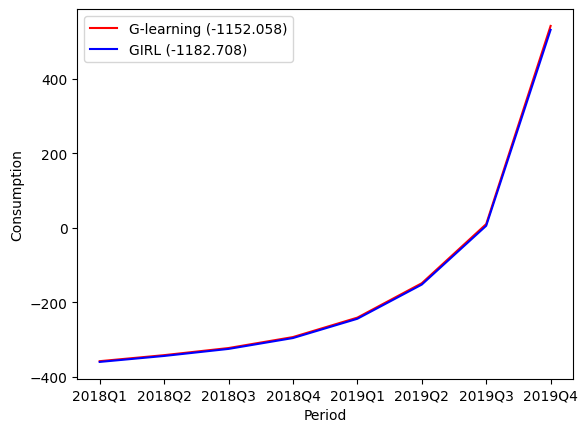

In [66]:
plt.plot(investment_periods,consumption/num_sim, label='G-learning (' + str(np.round(np.sum(consumption/num_sim),3)) + ')', color='red')
plt.plot(investment_periods,consumption_GIRL/num_sim, label='GIRL (' + str(np.round(np.sum(consumption_GIRL/num_sim),3)) + ')', color='blue')
plt.legend()
plt.xlabel('Period')
plt.ylabel('Consumption')

In [67]:
returns_all_GIRL=returns_all

SR_GIRL=0
for i in range(num_sim):
  SR_GIRL+=(np.mean(returns_all_GIRL[i])-R*dt)/np.std(returns_all_GIRL[i])

SR_GIRL/=num_sim
print(SR_GIRL)

r_GIRL=np.array([0]*num_steps, dtype='float64')
for n in range(num_steps):
  for i in range(num_sim):
    r_GIRL[n]+=returns_all_GIRL[i][n]
  r_GIRL[n]/=num_sim

0.44834388351316606


Text(0, 0.5, 'Sample Mean Returns')

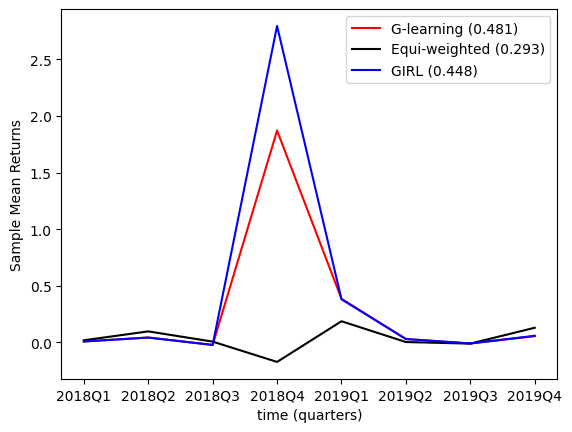

In [68]:
plt.plot(investment_periods, r_G, label='G-learning (' + str(np.round(SR_G,3)) + ')', color='red')
plt.plot(investment_periods,r_fixed, label='Equi-weighted (' + str(np.round(SR_fixed,3)) + ')', color='black')
plt.plot(investment_periods,r_GIRL, label='GIRL (' + str(np.round(SR_GIRL,3)) + ')', color='blue')

plt.legend()
plt.xlabel('time (quarters)')
plt.ylabel('Sample Mean Returns')